# Sommaire
* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Prétraitement des données textuelles](#ii)
    * [1) Catégories de produits](#ii1)
    * [2) Description](#ii2)
    * [3) Extraction de features](#ii3)
        * [i) Bag-of-words](#ii3i)
        * [ii) Word/sentence embedding](#ii3ii)
* [III) Prétraitement des données images](#iii)
    * [1) Opérations de retraitement d'image](#iii1)
    * [2) Extraction de features](#iii2)
        * [i) SIFT](#iii2i)
        * [ii) CNN/Transfer Learning](#iii2ii)
* [IV) Etude de faisabilité](#iv)
    * [1) t-SNE](#iv1)
    * [2) Etude de faisabilité](#iv2)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
Sur la marketplace e-commerce de Place de marché, les vendeurs proposent des articles en postant une photo et une description. L'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs. Pour faciliter la mise en ligne de nouveaux articles et la recherche de produits, il est nécessaire d'automatiser cette tâche d'attribution de catégorie.

Dans ce notebook, nous étudions la faisabilité d'un moteur de classification automatique à partir du texte et de l'image.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('display.max_columns', None)

In [2]:
#Les descriptions
data_desc = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print("Nombre de descriptions :", len(data_desc))
data_desc.head(5)

Nombre de descriptions : 1050


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
#Liste des noms d'images
data_image = os.listdir('Images')
print("Nombre d'images :", len(data_image))
data_image[:5]

Nombre d'images : 1050


['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

In [4]:
#Bonne nouvelle, on a le même nombre de descriptions et d'images !
#On va vérifier que les noms correspondent
#On trie les noms de fichier
data_image_rangé = sorted(data_image)
data_desc_rangé = data_desc.sort_values(by='image').reset_index(drop=True)

#On compare ligne par ligne
correspondance = all([img1 == img2 for img1, img2 in zip(data_image_rangé, data_desc_rangé['image'])])

if correspondance:
    print("Tous les noms correspondent.")
else:
    print("Il y a des différences dans les noms.")

Tous les noms correspondent.


# II) Prétraitement des données textuelles <a class="anchor" id="ii"></a>
## 1) Catégories de produits <a class="anchor" id="ii1"></a>

In [5]:
#Afin d'identifier les catégories de produits, on zoome sur product_category_tree
pd.set_option('display.max_colwidth', None)
data_desc['product_category_tree'].head(10)

0                             ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
3      ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]
4               ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]
5                                                                                  ["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]
6                                                                                        ["Watches >> Wrist Watches >> Camerii Wrist Watches"]

In [6]:
#Les produits semblent avoir plusieurs types de catégorie, on va se focaliser sur les 2 principaux pour l'instant
pd.reset_option('display.max_colwidth') #Avant que j'oublie
data_desc['product_category_tree'] = data_desc['product_category_tree'].str.strip('["]')  #On retire les crochets et guillemets
data_desc['product_category_tree'] = data_desc['product_category_tree'].str.split(' >> ')  #On divise les catégories

data_desc[['categorie_1', 'categorie_2']] = data_desc['product_category_tree'].apply(lambda x: pd.Series([x[0], x[1] if len(x) > 1 else None]))
data_desc.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie_1,categorie_2
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen


In [7]:
print("Nombre de catégories 1 :", data_desc['categorie_1'].nunique())
print("Nombre de catégories 2 :", data_desc['categorie_2'].nunique())

Nombre de catégories 1 : 7
Nombre de catégories 2 : 62


In [8]:
#Ca me semble énorme 62 catégories pour un jeu de données de 1050 articles, on va se contenter de la catégorie principale
#Maintenant les catégories identifiées, c'est la colonne description qui nous intéresse 
data_desc = data_desc[['uniq_id', 'product_name', 'image', 'description', 'categorie_1']]
data_desc.head(5)

,uniq_id,product_name,image,description,categorie_1
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [9]:
data_desc['categorie_1'].value_counts()

categorie_1
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Les catégories sont équitablement réparties.
## 2) Description <a class="anchor" id="ii2"></a>

In [10]:
pd.set_option('display.max_colwidth', 100)
data_desc['description'].head(10)

0    Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...
1    Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...
2    Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...
3    Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
4    Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...
5    Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch ...
6    Camerii WM64 Elegance Analog Watch  - For Men, Boys - Buy Camerii WM64 Elegance Analog Watch  - ...
7    T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys\r\n                         Price: Rs. 399\r\n...
8    Alfajr WY16B Youth Digital Watch  - For Men, Boys - Buy Alfajr WY16B Youth Digital Watch  - For ...
9    TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  -

In [11]:
#On va utiliser la description du dernier article du df comme fil rouge pour suivre les modifications apportées
#Voici donc la description brute
fil_rouge = data_desc.iloc[-1]['description']
print("Fil rouge :", fil_rouge)

Fil rouge : Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


In [12]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [13]:
#On commence par nettoyer les champs de texte (ponctuation et stopwords)
pd.reset_option('display.max_colwidth')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kent1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kent1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kent1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [14]:
#On définit notre fonction
from nltk.corpus import stopwords
from string import punctuation

#Stopwords en anglais
stop_words = set(stopwords.words('english'))

def texte_propre(texte):
    #Suppression de la ponctuation et mise en minuscules
    texte = ''.join([p for p in texte if p not in punctuation and p != '’']) #L'apostrophe droite n'est pas inclue dans la ponctuation alors je l'ajoute à part
    texte = texte.lower()

    #Suppression des stopwords
    texte = ' '.join([word for word in texte.split() if word not in stop_words]) #On laisse intentionnellement un espace ici
    return texte

In [15]:
#On applique
data_desc['description_propre'] = data_desc['description'].apply(texte_propre)

#Le fil rouge
fil_rouge = data_desc.iloc[-1]['description_propre']
print("Fil rouge :", fil_rouge)

Fil rouge : buy uberlyfe large vinyl sticker rs595 online uberlyfe large vinyl sticker best prices free shipping cash delivery genuine products 30 day replacement guarantee


In [16]:
#On définit une nouvelle fonction pour la visualisation des tokens
from collections import Counter

def visualisation_tokens(df, col):
    tokens = [token for texte in df[col].tolist() for token in (texte.split() if isinstance(texte, str) else texte)]
    token_frequence = Counter(tokens)
    tokens_courants = token_frequence.most_common(10)
    tokens, frequences = zip(*tokens_courants)
    plt.figure(figsize=(12,3))
    plt.bar(tokens, frequences)
    plt.title(f"Tokens les plus courants dans la colonne {col}", weight='bold')
    plt.xlabel('Tokens')
    plt.ylabel('Fréquence')

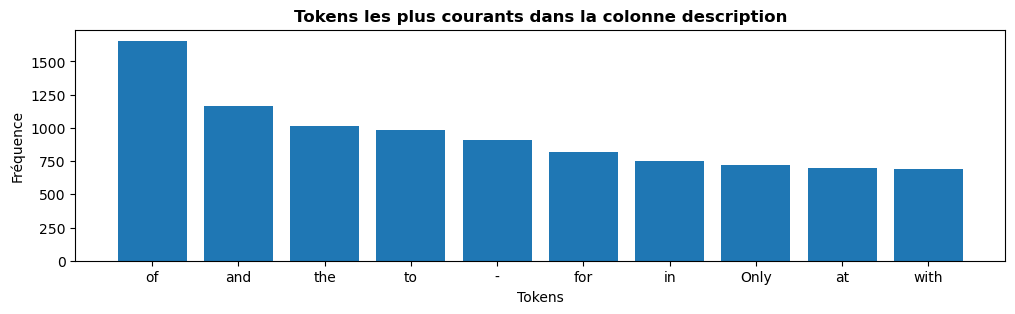

In [17]:
#On applique sur la colonne description
visualisation_tokens(data_desc, 'description')

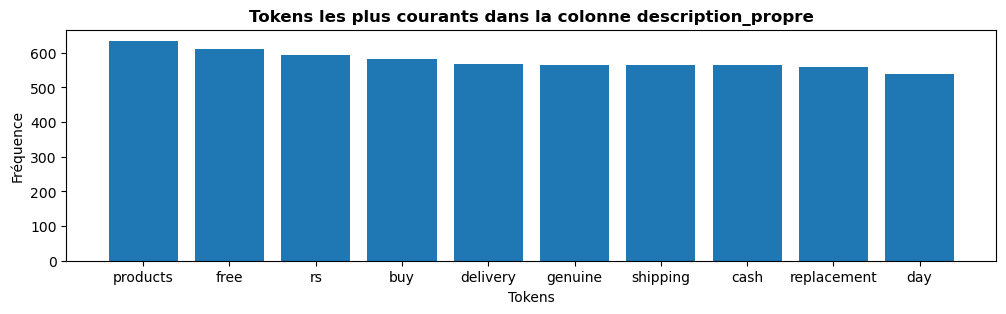

In [18]:
#On compare avec la description nettoyée
visualisation_tokens(data_desc, 'description_propre')

In [19]:
#On tokenize
from nltk.tokenize import word_tokenize

data_desc['description_token'] = data_desc['description_propre'].apply(word_tokenize)
fil_rouge = data_desc.iloc[-1]['description_token']
print("Fil rouge :", fil_rouge)

Fil rouge : ['buy', 'uberlyfe', 'large', 'vinyl', 'sticker', 'rs595', 'online', 'uberlyfe', 'large', 'vinyl', 'sticker', 'best', 'prices', 'free', 'shipping', 'cash', 'delivery', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee']


Fil rouge : ['buy', 'uberlyf', 'larg', 'vinyl', 'sticker', 'rs595', 'onlin', 'uberlyf', 'larg', 'vinyl', 'sticker', 'best', 'price', 'free', 'ship', 'cash', 'deliveri', 'genuin', 'product', '30', 'day', 'replac', 'guarante']


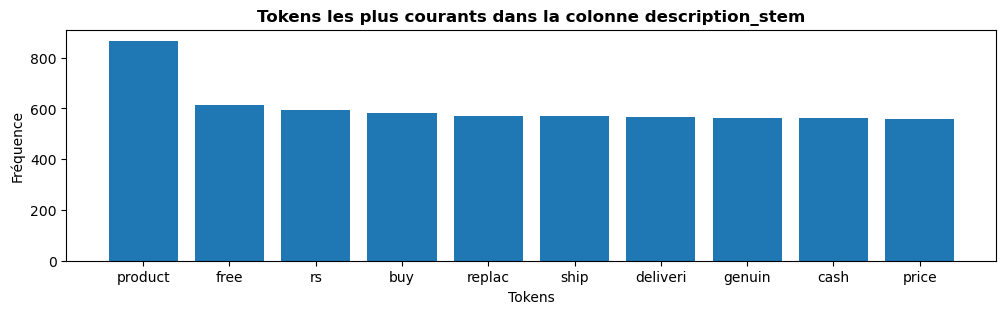

In [20]:
#2 options de racinalisation : lemmatisation ou stemming, on va tester les 2
from nltk.stem import PorterStemmer

#On initialise
stemmer = PorterStemmer()

#On applique
data_desc['description_stem'] = data_desc['description_token'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

#On visualise
visualisation_tokens(data_desc, 'description_stem')

#Le fil rouge
fil_rouge = data_desc.iloc[-1]['description_stem']
print("Fil rouge :", fil_rouge)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kent1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fil rouge : ['buy', 'uberlyfe', 'large', 'vinyl', 'sticker', 'rs595', 'online', 'uberlyfe', 'large', 'vinyl', 'sticker', 'best', 'price', 'free', 'shipping', 'cash', 'delivery', 'genuine', 'product', '30', 'day', 'replacement', 'guarantee']


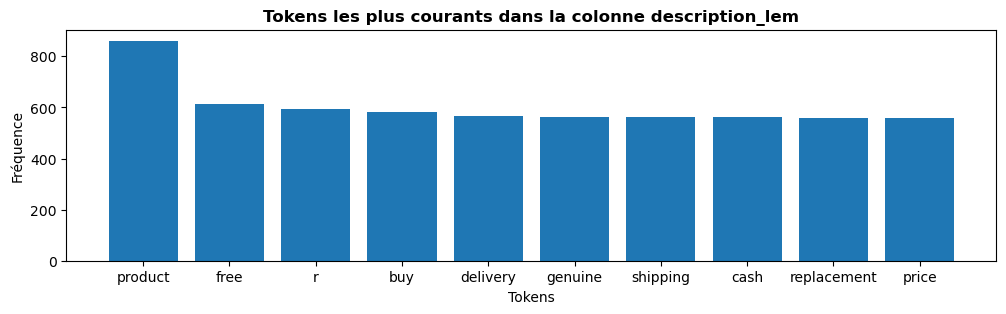

In [21]:
#On enchaîne
from nltk.stem import WordNetLemmatizer

#On télécharge les ressources nécessaires
nltk.download('wordnet')

#On initialise
lemmatizer = WordNetLemmatizer()

#On applique
data_desc['description_lem'] = data_desc['description_token'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

#On visualise
visualisation_tokens(data_desc, 'description_lem')

#Le fil rouge
fil_rouge = data_desc.iloc[-1]['description_lem']
print("Fil rouge :", fil_rouge)

In [22]:
#On compte le nombre de mots uniques pour chaque option de racinalisation
#Créer des ensembles supprime les doublons
print("Nombre de mots après stemming :", data_desc['description_stem'].apply(lambda x: len(x)).sum())
mots_uniques_stem = list(set([token for tokens in data_desc['description_stem'] for token in tokens]))
print("Nombre de mots uniques après stemming :", len(mots_uniques_stem))
print("Nombre de mots après lemmatisation :", data_desc['description_lem'].apply(lambda x: len(x)).sum())
mots_uniques_lem = list(set([token for tokens in data_desc['description_lem'] for token in tokens]))
print("Nombre de mots uniques après lemmatisation :", len(mots_uniques_lem))

Nombre de mots après stemming : 59088
Nombre de mots uniques après stemming : 5594
Nombre de mots après lemmatisation : 59088
Nombre de mots uniques après lemmatisation : 6157


In [23]:
#A partir d'ici on va utiliser le corpus lemmatisé, la lemmatisation est généralement plus précise car elle prend en compte le contexte grammatical
#On affiche le nombre de mots par catégorie, ainsi que dans tout le corpus
nb_mots_categ = pd.DataFrame(index=mots_uniques_lem, columns=data_desc['categorie_1'].unique())

#Boucle sur les catégories
for categorie in data_desc['categorie_1'].unique():
    categorie_data = data_desc[data_desc['categorie_1'] == categorie]
    decompte_mots_categ = Counter()

    #Boucle sur les tokens
    for tokens in categorie_data['description_lem']:
        decompte_mots_categ.update(tokens)

    #On remplit le df avec les occurences par catégorie
    for mot in mots_uniques_lem:
        nb_mots_categ.loc[mot, categorie] = decompte_mots_categ[mot]

#On ajoute une colonne Corpus total et Pourcentage
nb_mots_categ['Corpus total'] = nb_mots_categ.sum(axis=1)
nb_mots_categ['Pourcentage'] = (nb_mots_categ['Corpus total'] / len(data_desc) * 100).astype(float).round(2)
nb_mots_categ = nb_mots_categ.sort_values('Corpus total', ascending=False)
nb_mots_categ.head(20)

,Home Furnishing,Baby Care,Watches,Home Decor & Festive Needs,Kitchen & Dining,Beauty and Personal Care,Computers,Corpus total,Pourcentage
product,93,61,136,130,129,157,155,861,82.00
free,76,44,134,83,57,106,112,612,58.29
r,128,81,8,64,91,110,112,594,56.57
buy,77,35,134,82,57,101,95,581,55.33
delivery,74,34,134,77,51,103,94,567,54.00
genuine,74,34,134,76,51,101,94,564,53.71
cash,74,34,134,76,51,101,94,564,53.71
shipping,74,34,134,76,51,101,94,564,53.71
replacement,3,14,134,76,51,105,176,559,53.24
price,55,70,6,146,139,72,69,557,53.05


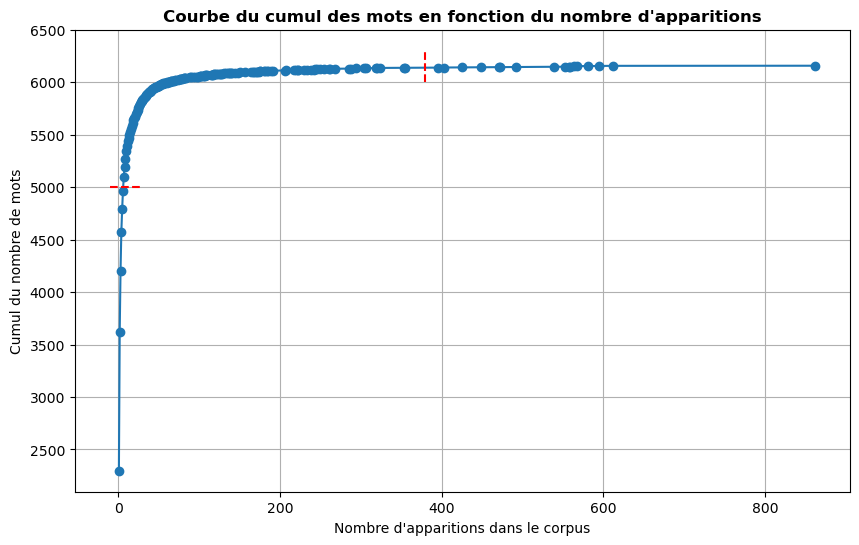

In [24]:
#Certains mots reviennent très souvent et sont assez génériques, donc ils n'apportent rien à l'analyse
#En revanche, d'autres apportent beaucoup d'information (ex : mug, watch), aussi on s'intéressera au pourcentage par catégorie plutôt qu'au count (on y arrive très vite)
#On va donc borner en retirant les mots qui apparaissent soit trop peu (bruit), soit trop souvent (peu informatifs)

#On enregistre la fréquence d'apparition des mots
frequence_mots = nb_mots_categ['Corpus total'].value_counts().sort_index()

#Graphique
plt.figure(figsize=(10,6))
plt.plot(frequence_mots.index, frequence_mots.cumsum(), marker='o')
plt.xlabel('Nombre d\'apparitions dans le corpus')
plt.ylabel('Cumul du nombre de mots')
plt.title('Courbe du cumul des mots en fonction du nombre d\'apparitions', weight='bold')
plt.grid(True)

plt.plot([380, 380], [6000, 6300], color='red', linestyle='--')
plt.plot([-10, 30], [5000, 5000], color='red', linestyle='--')

plt.show()

In [25]:
#Je décide de placer mes bornes pour isoler les points clairsemés
#Pour la borne basse, il s'agit des mots qui apparaissent moins de 7 fois dans le jeu de données
nb_mots_categ = nb_mots_categ.loc[nb_mots_categ['Corpus total'] > 6]
nb_mots_categ.tail(5)

,Home Furnishing,Baby Care,Watches,Home Decor & Festive Needs,Kitchen & Dining,Beauty and Personal Care,Computers,Corpus total,Pourcentage
cleaner,0,0,0,0,1,0,6,7,0.67
pro13,0,0,0,0,0,0,7,7,0.67
pulse,0,0,0,0,0,7,0,7,0.67
hz,0,0,0,0,0,0,7,7,0.67
learning,0,0,0,0,0,0,7,7,0.67


In [26]:
#Pour la borne haute, il s'agit des mots qui ressortent plus de 380 fois dans le jeu de données, ce qui correspond à ~38% du nombre de lignes du corpus
#Cela signifie qu'on conserve tous les mots qui apparaissent entre 7 et 380 fois dans le corpus
#Mais on ne supprime pas tous les mots qui apparaissent plus de 380 fois, comme mentionné plus haut, on s'intéresse au pourcentage
#On conservera les mots qui apparaissent dans une catégorie dans plus de 50% des cas

pourcent_mots_categ = nb_mots_categ.copy()
for categorie in data_desc['categorie_1'].unique():
    pourcent_mots_categ[categorie] = (nb_mots_categ[categorie] / nb_mots_categ['Corpus total'] * 100).astype(float).round(2)

#On définit une fonction pour mettre en surbrillance la cellule de chaque ligne ayant la valeur la plus élevée, si elle est supérieure à 50%
def highlight_max(data):
    #On créé un df vide
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    
    #Boucle sur chaque ligne du df
    for i in range(len(data)):
        #On trouve la colonne ayant la valeur la plus élevée (en excluant Corpus total et Pourcentage)
        max_col = data.iloc[i, :-2].idxmax()
        
        #Surbrillance si la valeur est supérieure à 50%
        if data.loc[data.index[i], max_col] >= 50:
            styles.at[data.index[i], max_col] = 'background-color: green'
    
    return styles

#On applique
styled_pourcent_mots_categ = pourcent_mots_categ[pourcent_mots_categ['Corpus total'] >= 380].style.apply(lambda x: highlight_max(x), axis=None).format('{:.2f}')
styled_pourcent_mots_categ

,Home Furnishing,Baby Care,Watches,Home Decor & Festive Needs,Kitchen & Dining,Beauty and Personal Care,Computers,Corpus total,Pourcentage
product,10.80,7.08,15.80,15.10,14.98,18.23,18.00,861.00,82.00
free,12.42,7.19,21.90,13.56,9.31,17.32,18.30,612.00,58.29
r,21.55,13.64,1.35,10.77,15.32,18.52,18.86,594.00,56.57
buy,13.25,6.02,23.06,14.11,9.81,17.38,16.35,581.00,55.33
delivery,13.05,6.00,23.63,13.58,8.99,18.17,16.58,567.00,54.00
genuine,13.12,6.03,23.76,13.48,9.04,17.91,16.67,564.00,53.71
cash,13.12,6.03,23.76,13.48,9.04,17.91,16.67,564.00,53.71
shipping,13.12,6.03,23.76,13.48,9.04,17.91,16.67,564.00,53.71
replacement,0.54,2.50,23.97,13.60,9.12,18.78,31.48,559.00,53.24
price,9.87,12.57,1.08,26.21,24.96,12.93,12.39,557.00,53.05


In [27]:
#Seules 2 lignes remplissent les conditions, on supprime les autres
plus_380 = pourcent_mots_categ[pourcent_mots_categ['Corpus total'] >= 380]
moins_380 = pourcent_mots_categ[pourcent_mots_categ['Corpus total'] < 380]
plus_380_filtré = plus_380[(plus_380.iloc[:, :-2] > 50).any(axis=1)]

#On combine
pourcent_mots_categ_filtré = pd.concat([plus_380_filtré, moins_380])

# Afficher les 20 premières lignes du DataFrame filtré
pourcent_mots_categ_filtré.head(20)

,Home Furnishing,Baby Care,Watches,Home Decor & Festive Needs,Kitchen & Dining,Beauty and Personal Care,Computers,Corpus total,Pourcentage
cm,31.17,8.91,0.00,52.50,4.45,1.86,1.11,539,51.33
mug,0.00,0.89,0.00,0.00,99.11,0.00,0.00,449,42.76
watch,0.00,0.56,98.31,0.00,0.00,0.00,1.13,355,33.81
color,18.08,21.75,7.06,20.06,12.99,11.86,8.19,354,33.71
type,11.42,26.23,3.40,12.96,15.74,14.51,15.74,324,30.86
baby,0.62,98.75,0.00,0.31,0.00,0.31,0.00,320,30.48
pack,27.59,23.20,0.31,12.54,22.57,9.40,4.39,319,30.38
material,17.97,10.78,2.61,16.67,38.89,7.19,5.88,306,29.14
set,13.49,18.09,0.00,6.58,14.14,36.84,10.86,304,28.95
box,15.65,22.79,1.70,17.35,15.65,17.35,9.52,294,28.00


In [28]:
mots_uniques = pourcent_mots_categ_filtré.index
print("Nombre de mots retenus dans l'ensemble du corpus :", len(mots_uniques))

Nombre de mots retenus dans l'ensemble du corpus : 1179


Fil rouge : ['large', 'vinyl', 'sticker', 'large', 'vinyl', 'sticker', 'best']


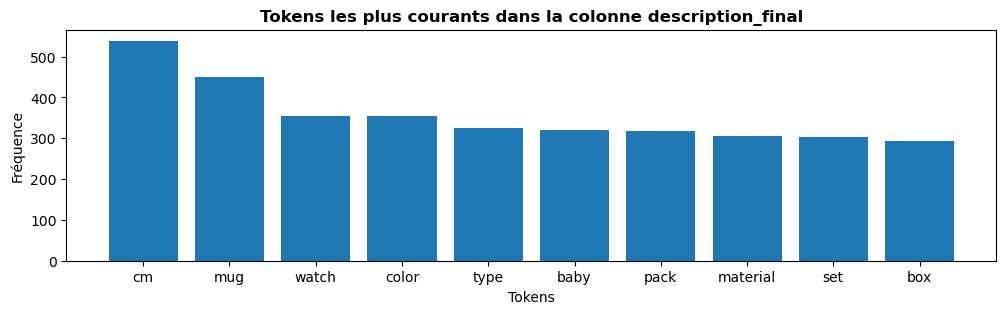

In [29]:
#On créé désormais une nouvelle colonne dans data_desc en filtrant sur les mots retenus
data_desc['description_final'] = data_desc['description_lem'].apply(lambda tokens: [mot for mot in tokens if mot in mots_uniques])

#On visualise
visualisation_tokens(data_desc, 'description_final')

#Le fil rouge
fil_rouge = data_desc.iloc[-1]['description_final']
print("Fil rouge :", fil_rouge)

In [30]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


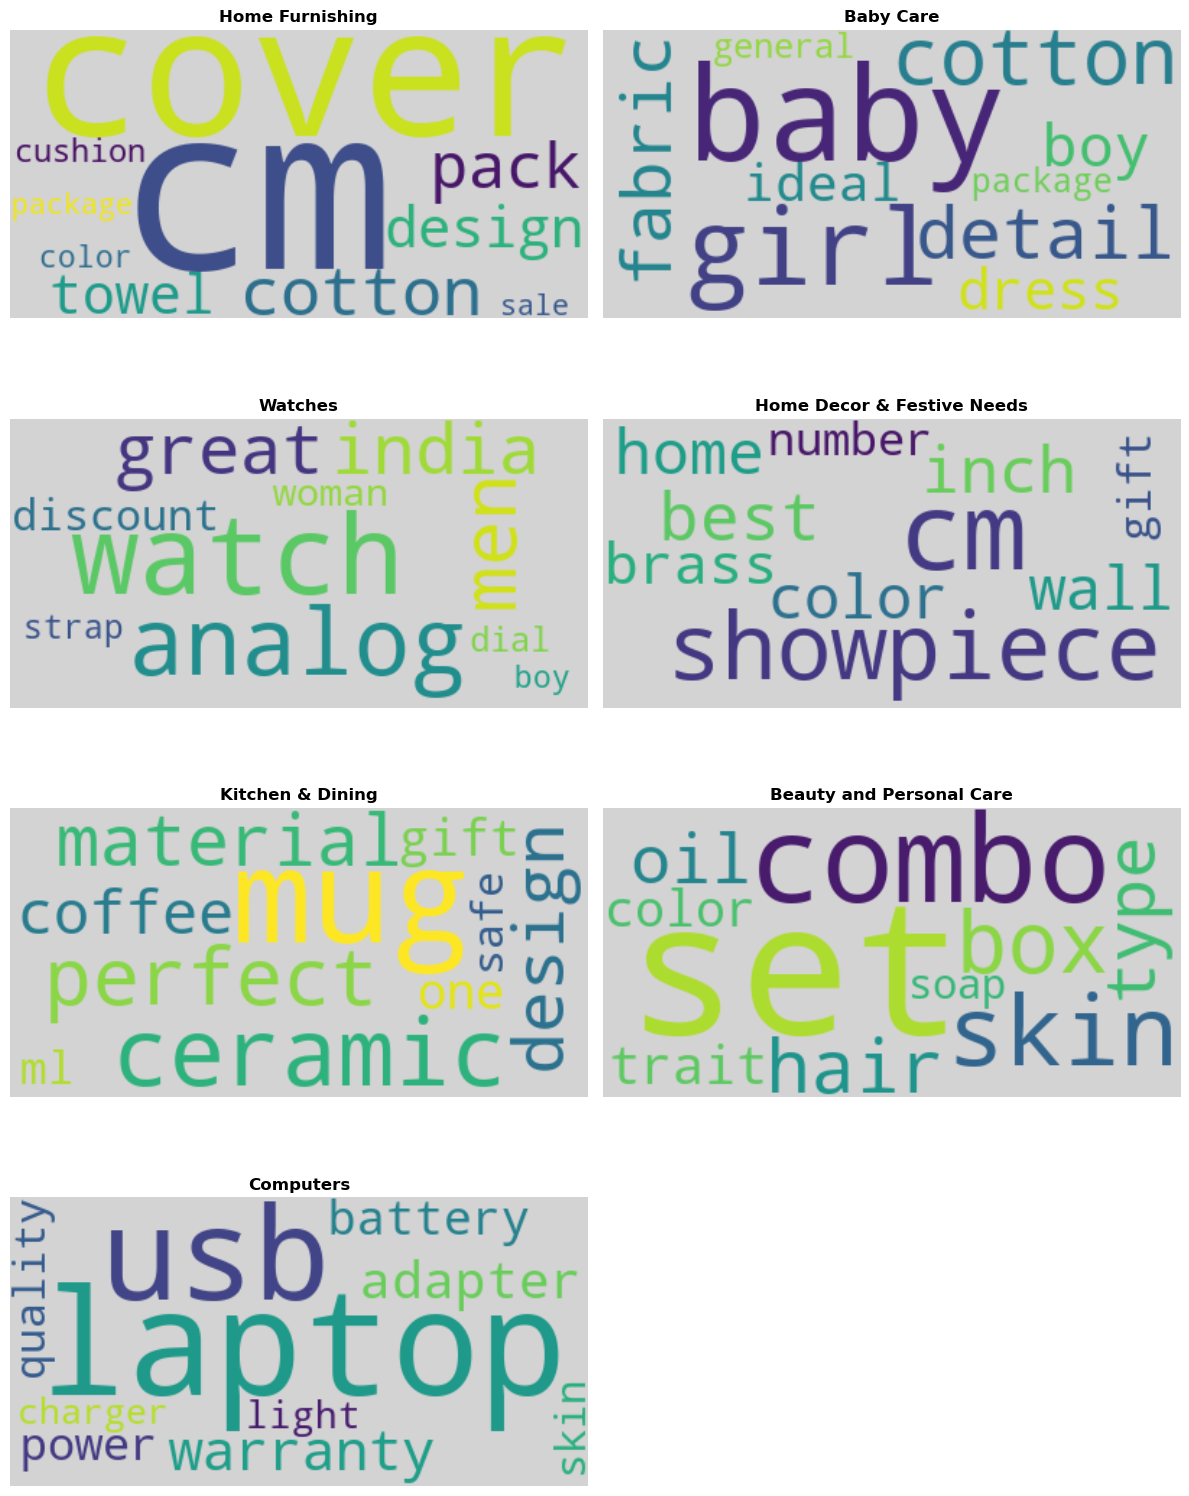

In [31]:
#Pour visualiser, on va générer un wordcloud par catégorie
from wordcloud import WordCloud

#On définit la fonction
def generate_wordcloud(mots_frequents):
    wordcloud = WordCloud(width=400, height=200, background_color='lightgrey').generate_from_frequencies(mots_frequents)
    return wordcloud

#On créé une liste pour stocker les wordclouds et leurs titres
wordclouds = []
titres = []

#Boucle par catégorie
for categorie in data_desc['categorie_1'].unique():
    categorie_data = data_desc[data_desc['categorie_1'] == categorie]
    decompte_mots_categ = Counter()

    #Boucle sur les tokens
    for tokens in categorie_data['description_final']:
        decompte_mots_categ.update(tokens)
    
    #Top 10 des mots les plus fréquents
    mots_plus_frequents = dict(decompte_mots_categ.most_common(10))
    
    #Wordcloud par catégorie
    wordcloud = generate_wordcloud(mots_plus_frequents)
    
    #On ajoute aux listes
    wordclouds.append(wordcloud)
    titres.append(categorie)

#Nombre de lignes et de colonnes
num_cols = 2
num_lignes = (len(wordclouds) + num_cols - 1) // num_cols

#Figure et axes
fig, axes = plt.subplots(num_lignes, num_cols, figsize=(12,16))
axes = axes.flatten()

#Boucle sur les wordclouds/catégories
for i, (wordcloud, titre) in enumerate(zip(wordclouds, titres)):
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(titre, weight='bold')

#Suppression du dernier sous-graphique car non utilisé
for j in range(len(wordclouds), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [32]:
#On en a fini avec data_desc, on exporte pour le prochain notebook
data_desc.to_csv('data_desc.csv', index=False)

## 3) Extraction de features <a class="anchor" id="ii3"></a>
### i) Bag-of-words <a class="anchor" id="ii3i"></a>

In [33]:
#2 méthodes, comptage simple et Tf-idf
#On commence par le comptage simple
from sklearn.feature_extraction.text import CountVectorizer

#On va générer des dfs avec énormément de colonnes
pd.reset_option('display.max_columns')

vectorizer = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|•') #Inclut les mots composés de caractères alphanumériques ainsi que le caractère spécial •
X = vectorizer.fit_transform(data_desc['description_final'].apply(lambda tokens: ' '.join(tokens))) #On transforme description_final en liste de chaînes de caractères

#On extrait les features
feature_names = vectorizer.get_feature_names_out()
comptage_simple = pd.DataFrame(X.toarray(), columns=feature_names)
print("Shape :", comptage_simple.shape)
comptage_simple.head(5)

Shape : (1050, 1179)


,0,00,01,10,100,1000,105,11,12,120,...,woven,wow,wrap,x,year,yellow,yes,yet,youre,•
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0
2,0,0,0,1,2,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
#Le fil rouge
fil_rouge = comptage_simple.iloc[-1]
fil_rouge[fil_rouge != 0]

best       1
large      2
sticker    2
vinyl      2
Name: 1049, dtype: int64

In [35]:
#On enchaîne avec le Tf-idf
#TF = Term Frequency -> Plus un mot apparaît fréquemment dans un document, plus il est important
#IDF = Inverse Document Frequency -> Un mot qui apparaît dans de nombreux documents est considéré moins important pour un document particulier
#En d'autres termes, si le mot n'apparaît pas dans le document : 0 ; s'il n'apparaît QUE dans ce document : 1
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|•') #Même remarque qu'avant
X_tfidf = vectorizer_tfidf.fit_transform(data_desc['description_final'].apply(lambda tokens: ' '.join(tokens))) #Idem

tf_idf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names).round(3)
print("Shape :", tf_idf.shape)
tf_idf.head(5)

Shape : (1050, 1179)


,0,00,01,10,100,1000,105,11,12,120,...,woven,wow,wrap,x,year,yellow,yes,yet,youre,•
0,0.000,0.0,0.0,0.000,0.046,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.0,0.0
1,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.000,0.19,0.073,0.0,0.0,0.0
2,0.000,0.0,0.0,0.048,0.085,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.04,0.045,0.00,0.000,0.0,0.0,0.0
3,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.000,0.00,0.044,0.0,0.0,0.0
4,0.159,0.0,0.0,0.000,0.078,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.000,0.00,0.035,0.0,0.0,0.0


In [36]:
#Le fil rouge
fil_rouge = tf_idf.iloc[-1]
fil_rouge[fil_rouge != 0]

best       0.146
large      0.610
sticker    0.551
vinyl      0.551
Name: 1049, dtype: float64

### ii) Word/sentence embedding <a class="anchor" id="ii3ii"></a>
Cette méthode consiste à convertir les mots en vecteurs qui capturent les relations entre les mots. Cela permet au modèle de comprendre la signification et la similarité des mots, d'aboutir à une réduction de dimensionnalité et d'être utilisé pour des tâches de classification (par exemple). Nous en testerons 3 : Word2Vec, BERT et USE.

In [36]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [37]:
#On commence par Word2Vec
from gensim.models import Word2Vec

#On utilise la version tokenisée de la description
w2v = Word2Vec(sentences=data_desc['description_token'], vector_size=100, window=5, min_count=5)
w2v.get_latest_training_loss(), w2v.wv.vectors.shape

(0.0, (1666, 100))

In [38]:
#On transforme ces 1666 tokens en un vecteur de 100 dimensions
def description_en_vecteur(description, modèle):
    vecteurs = [modèle.wv[mot] for mot in description if mot in modèle.wv]
    return np.mean(vecteurs, axis=0) if vecteurs else np.zeros(modèle.vector_size)

#On applique la fonction à la colonne description_token
description_vecteurs = data_desc['description_token'].apply(lambda x: description_en_vecteur(x, w2v))

#On convertit en df
df_w2v = pd.DataFrame(description_vecteurs.tolist())
print("Shape :", df_w2v.shape)
df_w2v.head(5)

Shape : (1050, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.001830,0.223876,-0.134167,-0.273203,-0.019019,-0.416753,0.200799,0.558877,-0.124791,-0.210537,...,0.607687,0.005477,-0.347827,0.118801,0.309753,0.267205,0.012919,-0.311291,0.128603,-0.332053
1,0.102886,0.173381,-0.168770,-0.406373,-0.005012,-0.546179,0.183115,0.710041,-0.012398,-0.257345,...,0.791463,-0.042570,-0.390485,0.123628,0.309599,0.372994,-0.026226,-0.377607,0.132463,-0.489347
2,0.003084,0.221575,-0.134125,-0.265583,-0.020548,-0.434255,0.179730,0.587325,-0.111749,-0.245395,...,0.611608,0.005919,-0.350841,0.100435,0.329907,0.289135,-0.015989,-0.305862,0.145100,-0.338641
3,0.067829,0.188939,-0.095799,-0.371889,-0.023770,-0.476475,0.202417,0.548149,-0.091408,-0.158785,...,0.656532,-0.043615,-0.367783,0.123961,0.257905,0.255503,0.058915,-0.374845,0.103741,-0.401902
4,0.035945,0.230614,-0.110306,-0.349725,-0.032128,-0.485233,0.217602,0.586469,-0.128470,-0.197870,...,0.670794,-0.024820,-0.391353,0.125869,0.304808,0.273438,0.043125,-0.378653,0.132078,-0.389216


In [39]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [40]:
#On enchaîne avec BERT
#J'ai eu des difficulté pour installer les librairies nécessaires avec pip, donc je suis passé par conda
#Ce modèle a son propre tokenizer, donc on va utiliser la description nettoyée
#La librairie tqdm permet d'afficher une barre de progression
from transformers import BertTokenizer, BertModel
import torch
from tqdm.auto import tqdm

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
modèle_bert = BertModel.from_pretrained('bert-base-uncased')

def description_en_vecteur_bert(description, tokenizer, modèle):
    #On tokenise
    inputs = tokenizer(description, return_tensors='pt', padding=True, truncation=True)
    
    #On exécute le modèle
    with torch.no_grad():
        outputs = modèle(**inputs)
    
    #On récupère les embeddings (dernière couche cachée)
    embeddings = outputs.last_hidden_state[0].numpy()
    
    #On calcule la moyenne des embeddings
    return np.mean(embeddings, axis=0) if len(embeddings) > 0 else np.zeros(modèle.config.hidden_size)

#Pour suivre l'application de la fonction
tqdm.pandas(desc="Extraction des vecteurs BERT ")

#On applique (progress_apply permet de suivre la progression)
description_vecteurs_bert = data_desc['description_propre'].progress_apply(lambda x: description_en_vecteur_bert(x, tokenizer_bert, modèle_bert))

#On convertit en df
df_bert = pd.DataFrame(description_vecteurs_bert.tolist())
print("Shape :", df_bert.shape)
df_bert.head(5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Extraction des vecteurs BERT :   0%|          | 0/1050 [00:00<?, ?it/s]

Shape : (1050, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.124445,0.054643,0.745837,-0.076223,0.356784,-0.009883,0.091342,0.054578,-0.106462,-0.298481,...,-0.058418,-0.413275,0.115880,0.084033,0.074581,0.047487,-0.393035,0.010718,-0.058127,-0.108062
1,0.069017,0.010439,0.456903,0.059805,0.178445,-0.078450,0.140947,-0.050507,-0.060219,-0.084226,...,-0.036486,-0.045008,0.091436,-0.091352,0.156523,0.086392,-0.320357,-0.171230,-0.145926,0.157661
2,-0.017375,0.089198,0.595399,-0.037944,0.265422,-0.068979,-0.181930,0.157017,-0.188924,-0.137905,...,-0.197602,-0.191484,0.218699,0.027080,0.203404,0.157411,-0.387754,-0.149763,-0.195557,0.012566
3,0.090395,0.024636,0.553355,-0.085060,0.242439,-0.143951,0.063397,0.232201,-0.009187,0.114097,...,-0.050616,-0.082828,0.077117,-0.085437,0.087345,-0.029300,-0.400052,0.017379,0.032216,-0.114790
4,0.068926,0.081408,0.547503,-0.082717,0.218431,-0.157283,-0.042325,0.228075,0.026963,-0.032273,...,-0.038384,-0.073998,0.213207,-0.119450,0.088815,0.085026,-0.495426,0.062250,-0.003375,-0.054963


In [41]:
#C'était long donc je vais enregistrer ce df afin de ne pas avoir à relancer le code à chaque fois que j'ouvre le notebook
df_bert.to_csv('df_bert.csv', index=False)

In [48]:
#On enchaîne avec USE
#A l'instar de BERT, ce modèle tokenise par lui-même, donc on utilise une nouvelle fois la description nettoyée
import tensorflow as tf
import tensorflow_hub as hub

#On charge l'Universal Sentence Encoder depuis TensorFlow-Hub
modèle_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def description_en_vecteur_use(description, modèle):
    #On récupère les embeddings
    embeddings = modèle([description])
    return embeddings.numpy().flatten()

#Même explication que précédemment
tqdm.pandas(desc="Extraction des vecteurs USE ")

#On applique
description_vecteurs_use = data_desc['description_propre'].progress_apply(lambda x: description_en_vecteur_use(x, modèle_use))

#On convertit en df
df_use = pd.DataFrame(description_vecteurs_use.tolist())
print("Shape :", df_use.shape)
df_use.head(5)

Extraction des vecteurs USE :   0%|          | 0/1050 [00:00<?, ?it/s]

Shape : (1050, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.055005,-0.054896,0.042346,0.053071,0.002827,0.050757,-0.042258,0.050391,-0.050574,-0.026556,...,-0.031752,-0.055289,-0.054834,0.054044,-0.024321,-0.044849,0.038830,0.037141,0.045985,-0.043652
1,-0.052484,-0.037165,0.024882,0.039730,0.056149,0.059022,0.056016,-0.021904,-0.053605,-0.050154,...,0.035828,-0.058756,-0.051211,-0.055233,-0.026315,-0.051854,-0.012080,0.025706,0.027932,0.031702
2,-0.054760,-0.051396,-0.018294,0.054393,0.051965,0.054436,0.051782,0.042289,-0.053850,0.032794,...,0.052366,-0.054802,-0.048288,0.000273,0.047817,-0.054347,0.043603,0.052648,-0.043429,-0.048380
3,-0.054812,-0.053540,0.050080,0.054246,0.054660,0.041311,0.037399,0.045418,-0.023155,-0.051095,...,-0.004562,-0.054956,-0.016702,0.043513,-0.047887,-0.046848,0.052174,0.051761,0.002772,-0.053800
4,-0.053420,-0.052487,0.048479,0.051792,0.053450,0.052189,-0.007390,0.046681,0.007187,-0.048705,...,0.003157,-0.053496,-0.051321,0.008185,-0.052504,-0.051193,0.053166,0.053399,-0.021798,-0.051815


In [49]:
#C'était moins long, mais on va quand même l'enregistrer dans un df puis on passe aux images
df_use.to_csv('df_use.csv', index=False)

# III) Prétraitement des données images <a class="anchor" id="iii"></a>
## 1) Opérations de retraitement d'image <a class="anchor" id="iii1"></a>

On va garder notre fil rouge et afficher l'image correspondant à la description retenue plus haut après chaque étape de retraitement d'image :
- Conversion en niveaux de gris -> Chaque pixel ne prend qu'une seule valeur (intenisté lumineuse) au lieu de trois (RGB), ce qui simplifie l'analyse
- Réduction du bruit -> Lisse l'image et supprime les détails non pertinents
- Egalisation d'histogramme -> Redistribue les intensités de pixels pour couvrir toute la gamme de niveaux de gris
- Floutage -> Lisse l'image pour réduire le bruit encore davantage

In [44]:
pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.1/38.8 MB 762.6 kB/s eta 0:00:51
   ---------------------------------------- 0.1/38.8 MB 726.2 kB/s eta 0:00:54
   ---------------------------------------- 0.1/38.8 MB 708.1 kB/s eta 0:00:55
   ---------------------------------------- 0.2/38.8 MB 697.2 kB/s eta 0:00:56
   ---------------------------------------- 0.2/38.8 MB 731.4 kB/s eta 0:00:53
   ---------------------------------------- 0.2/38.8 MB 752.5 kB/s eta 0:00:52
   ---------------------------------------- 0.3/38.8 MB 737.3 kB/s eta 0:00:53
   ---------------------------------------- 0.3/38.8 MB 752.2 kB/s eta 0:00:52
   ---------------------------------------- 0.4/38.8 MB 742.3 kB/s eta 0:00:52
   ---------------------------------------- 0.4/38.8 MB 734.3 kB/s eta

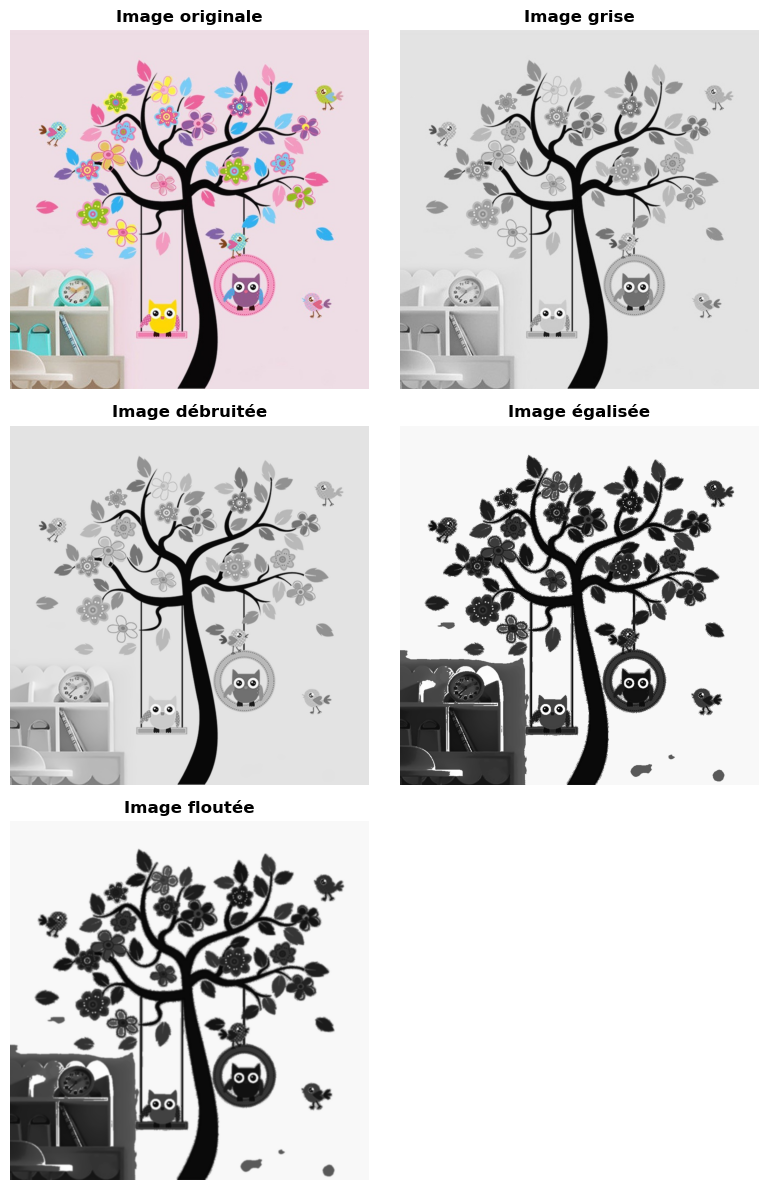

In [45]:
import cv2

#On créé un dossier pour enregistrer les images retraitées
os.makedirs('Images_retraitees', exist_ok=True)

#Image du fil rouge à traiter
image_path = os.path.join('Images', data_desc.iloc[-1]['image'])
save_path = os.path.join('Images_retraitees')

#Le retraitement mentionné plus haut
def retraitement_images(image_path, save_path):
    image = cv2.imread(image_path)
    image_grise = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Niveaux de gris
    image_bruit = cv2.fastNlMeansDenoising(image_grise) #Réduction du bruit
    image_égal = cv2.equalizeHist(image_bruit) #Egalisation d'histogramme
    image_flou = cv2.GaussianBlur(image_égal, (7, 7), 0) #Floutage
    
    #Enregistrement de l'image finale
    cv2.imwrite(os.path.join(save_path, os.path.basename(image_path)), image_flou)

    #On plot à chaque étape du retraitement d'image
    titres = ['Image originale', 'Image grise', 'Image débruitée', 'Image égalisée', 'Image floutée']
    images = [cv2.imread(image_path)] + [image_grise, image_bruit, image_égal, image_flou]
    
    fig, axes = plt.subplots(3, 2, figsize=(8,12))
    axes = axes.flatten()

    #Boucle sur les étapes de retraitement d'image
    for i, (image, titre) in enumerate(zip(images, titres)):
        ax = axes[i]
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(titre, weight='bold')
        ax.axis('off')

    #Suppression du dernier sous-graphique car non utilisé
    for j in range(len(images), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#On applique
retraitement_images(image_path, save_path)

## 2) Extraction de features <a class="anchor" id="iii2"></a>
### i) SIFT <a class="anchor" id="iii2i"></a>

L'algorithme SIFT (Scale-Invariant Feature Transform) permet de détecter les features dans une image. Il applique ensuite une transformation de la différence des Gaussiennes (DoG) à l'image à plusieurs échelles pour identifier les emplacements des features les plus distinctives, et écarter celles avec un faible contraste. Il est également insensible à l'orientation de l'image.

Nombre de features détectées : 1971


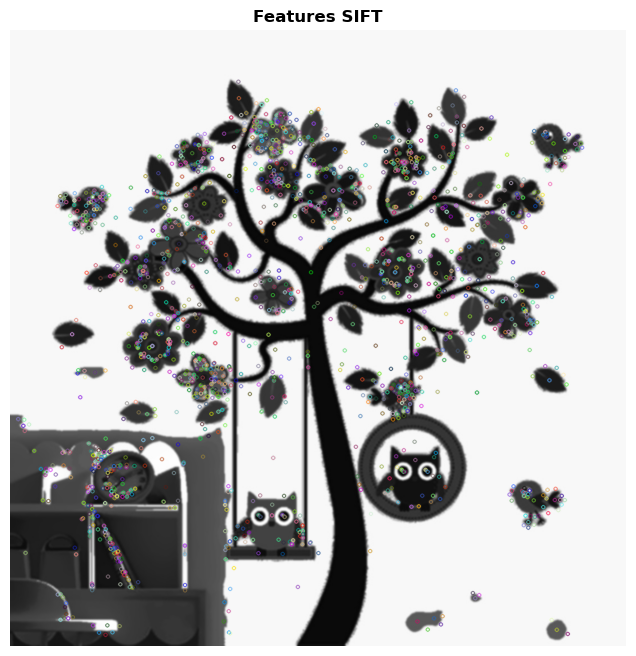

In [46]:
#On lit l'image fil rouge depuis son save_path
fil_rouge_path = os.path.join(save_path, os.path.basename(image_path))
image_fil_rouge = cv2.imread(fil_rouge_path)

#On initialise
sift = cv2.SIFT_create()

#On détecte et compte les features
keypoints, descriptors = sift.detectAndCompute(image_fil_rouge, None)
print(f"Nombre de features détectées : {len(keypoints)}")

#On affiche les features sur l'image puis on convertit en RGB
image_sift = cv2.drawKeypoints(image_fil_rouge, keypoints, None)
image_sift = cv2.cvtColor(image_sift, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(image_sift)
plt.axis('off')
plt.title('Features SIFT', weight='bold')
plt.show()

### ii) CNN/Transfer Learning <a class="anchor" id="iii2ii"></a>
Le modèle VGG16 est une architecture "Convolutional Neural Network" qui a été formé sur plus d'un million d'images et peut classer en 1000 classes d'objets. On va construire un nouveau modèle à partir de celui-ci, mais sans les 2 dernières couches. On utilise les couches inférieures du réseau pré-entraîné pour en extraire les features, puis on ajoute nos propres couches afin de procéder à la classification.

In [47]:
#Le modèle VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

modèle_VGG16 = VGG16()
modèle = Model(inputs=modèle_VGG16.inputs, outputs=modèle_VGG16.layers[-2].output)

print(modèle.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 881s 2us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [49]:
#Extraction des features
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

#Pour charger des images de grande taille
Image.MAX_IMAGE_PIXELS = None

#Liste vide pour enregistrer les features
image_features = []

#Boucle sur chaque image dans le dossier
for fichier_image in tqdm(data_image, desc="Extraction des features "):
    #Chemin où sont enregistrées les images
    fichier_image_path = os.path.join("Images", fichier_image)

    #On redimensionne en 224x224 car VGG16 accepte les images de cette taille
    image = load_img(fichier_image_path, target_size=(224, 224))
    
    #On convertit en array pour pouvoir manipuler
    image_array = img_to_array(image) 
    
    #On passe en 4D car VGG16 a la forme (batch_size, height, width, channels)
    image_4d = np.expand_dims(image_array, axis=0)
    
    #On rééquilibre les couleurs RGB
    image_rgb = preprocess_input(image_4d)
    
    #On extrait
    image_feature = modèle.predict(image_rgb, verbose=0)[0]
    
    #On enregistre les features dans la liste
    image_features.append(image_feature)

#On convertit la liste en df
image_features = pd.DataFrame(image_features)
image_features[:5]

Extraction des features :   0%|          | 0/1050 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,2.592806,2.698754,0.00000,3.298269,1.668665,0.000000,0.000000,0.000000,0.0,2.128206,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.877925,0.00000,2.967209
1,0.000000,0.000000,0.00000,2.220960,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,1.621776,2.381029,0.042124,0.389171,0.000000,0.16598,2.920202
2,0.000000,0.000000,0.00000,2.023537,0.000000,0.499071,2.574245,0.000000,0.0,0.000000,...,2.959453,0.018466,0.0,1.349823,0.000000,3.785173,0.000000,0.698539,0.00000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.167177,0.000000,0.000000,1.377321,0.0,1.556970,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.576265
4,0.000000,0.000000,1.52537,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.515819,0.0,0.037120,0.000000,1.204973,0.144978,0.000000,0.00000,3.427233


In [50]:
#On cherche désormais à ajouter la colonne categorie_1 à image_features
#Pour ce faire nous devons d'abord lui ajouter une colonne image (à partir de data_image), puis effectuer une jointure sur cette colonne avec data_desc
image_features['image'] = data_image
image_final = pd.merge(data_desc[['image', 'categorie_1']], image_features, on='image', how='inner')
image_final = image_final.drop(columns='image')
print("Shape :", image_final.shape) #On s'attend à 1050 lignes et 4097 colonnes (4096 features + categorie_1)
image_final[:5]

Shape : (1050, 4097)


,categorie_1,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,Home Furnishing,3.398617,0.859574,0.0,1.106562,2.266122,2.927241,2.446448,0.0,0.0,...,0.485877,0.0,0.0,0.472935,0.875755,0.783685,0.000000,0.000000,0.851056,0.0
1,Baby Care,0.000000,0.000000,0.0,1.172008,0.000000,0.000000,0.000000,0.0,0.0,...,1.169691,0.0,0.0,0.000000,0.000000,3.152507,0.000000,0.000000,0.000000,0.0
2,Baby Care,0.000000,0.000000,0.0,4.457806,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,5.270285,0.000000,1.297102,0.000000,0.0
3,Home Furnishing,0.000000,0.070988,0.0,2.046279,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,3.977749,0.000000,0.000000,0.000000,0.0
4,Home Furnishing,3.417154,0.000000,0.0,0.000000,1.012358,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,9.195914,0.139733,0.000000,1.735954,0.0


In [51]:
#Super nickel, on enregisre le df
image_final.to_csv('image_final.csv', index=False)

# IV) Etude de faisabilité <a class="anchor" id="iv"></a>
## 1) t-SNE <a class="anchor" id="iv1"></a>
Si on retient les modèles BERT, USE ainsi que le VGG-16, on a des jeux de données à respectivement 768, 512 et 4096 colonnes, impossible à visualiser sans réduire la dimensionnalité. Comme Linda nous a demandé une projection en 2 dimensions, on va utiliser le t-SNE. Seulement le t-SNE prend plusieurs hyperparamètres, et il convient de tester des valeurs différentes afin de retenir la meilleure combinaison possible.

Pour ce faire, nous nous appuierons sur l'index de Davies-Bouldin et le Silhouette Score, qui évaluent la qualité des clusters. On souhaite que DB tende vers 0 et Silhouette vers 1.

In [37]:
#On définit une fonction car on va l'utiliser avec BERT, USE et le VGG-16
#Je n'utilise pas de scaler car j'ai obtenu de meilleurs résultats sans
from sklearn.manifold import TSNE
from sklearn import metrics
from itertools import product
from tqdm.auto import tqdm

#Je l'appelle comme ça, parce que ça ressemble pas mal à GridSearchCV
def tsne_grid_search(df):
    #On définit les hyperparamètres à tester
    perplexities = list(range(10, 101, 10))
    learning_rates = [10, 100, 1000]
    metrics = ['euclidean', 'cosine', 'manhattan']
    inits = ['random', 'pca']

    #Toutes les combinaisons possibles
    param_combinations = list(product(perplexities, learning_rates, metrics, inits))

    #Liste vide pour enregistrer les résultats
    résultats_tsne = []

    #Boucle par combinaison d'hyperparamètres
    for perplexity, learning_rate, metric, init in tqdm(param_combinations, desc="Combinaisons d'hyperparamètres TSNE "):
        #Le TSNE
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, metric=metric, init=init, random_state=42)
        modèle_tsne = tsne.fit_transform(df.drop(columns=['categorie_1']))

        #On calcule les scores
        db_score = davies_bouldin_score(modèle_tsne, df['categorie_1'])
        silhouette = silhouette_score(modèle_tsne, df['categorie_1'])

        #On enregistre les résultats
        résultats_tsne.append({'perplexity': perplexity,
                               'learning_rate': learning_rate,
                               'metric': metric,
                               'init': init,
                               'db_score': db_score,
                               'silhouette_score': silhouette})

    #On convertit en df
    résultats_tsne_df = pd.DataFrame(résultats_tsne)

    #On ajoute des colonnes pour classer en fonction des scores
    résultats_tsne_df['rang_db'] = résultats_tsne_df['db_score'].rank()
    résultats_tsne_df['rang_silhouette'] = résultats_tsne_df['silhouette_score'].rank(ascending=False)
    résultats_tsne_df['rang_moyen'] = résultats_tsne_df[['rang_silhouette', 'rang_db']].mean(axis=1)

    #Puis on trie par rang_moyen
    résultats_tsne_df = résultats_tsne_df.sort_values('rang_moyen').reset_index(drop=True)
    
    return résultats_tsne_df[:10]

In [37]:
pip install --upgrade threadpoolctl

Note: you may need to restart the kernel to use updated packages.


In [47]:
#On commence par image_final
image_final = pd.read_csv('image_final.csv')
résultats_tsne_if = tsne_grid_search(image_final)
résultats_tsne_if

Combinaisons d'hyperparamètres TSNE :   0%|          | 0/180 [00:00<?, ?it/s]

,perplexity,learning_rate,metric,init,db_score,silhouette_score,rang_db,rang_silhouette,rang_moyen
0,30,1000,cosine,pca,1.315400,0.279240,1.0,1.0,1.0
1,60,10,manhattan,pca,1.369352,0.265332,2.0,2.0,2.0
2,70,10,euclidean,pca,1.386408,0.248908,3.0,14.0,8.5
3,80,10,cosine,pca,1.525620,0.255695,21.0,8.0,14.5
4,80,10,cosine,random,1.429819,0.246635,6.0,25.0,15.5
5,70,10,cosine,random,1.489740,0.247194,12.0,22.0,17.0
6,20,1000,cosine,random,1.535501,0.249852,22.0,13.0,17.5
7,70,100,manhattan,pca,1.475884,0.245717,10.0,30.0,20.0
8,60,10,cosine,pca,1.543646,0.248189,24.0,16.0,20.0
9,90,1000,cosine,random,1.564874,0.259863,38.0,4.0,21.0


In [38]:
#On enchaîne avec BERT et USE, mais il faut leur ajouter la colonne categorie_1
df_bert = pd.read_csv('df_bert.csv')
df_bert.insert(0, 'categorie_1', data_desc['categorie_1'].values)
df_bert[:5]

,categorie_1,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,Home Furnishing,-0.124445,0.054643,0.745837,-0.076223,0.356784,-0.009883,0.091342,0.054578,-0.106462,...,-0.058418,-0.413275,0.115880,0.084033,0.074581,0.047487,-0.393035,0.010718,-0.058127,-0.108062
1,Baby Care,0.069017,0.010439,0.456903,0.059805,0.178445,-0.078450,0.140947,-0.050507,-0.060219,...,-0.036486,-0.045008,0.091436,-0.091352,0.156523,0.086392,-0.320357,-0.171230,-0.145926,0.157661
2,Baby Care,-0.017375,0.089198,0.595399,-0.037944,0.265422,-0.068979,-0.181930,0.157017,-0.188924,...,-0.197602,-0.191484,0.218699,0.027080,0.203404,0.157411,-0.387754,-0.149763,-0.195557,0.012566
3,Home Furnishing,0.090395,0.024636,0.553355,-0.085060,0.242439,-0.143951,0.063397,0.232201,-0.009187,...,-0.050616,-0.082828,0.077117,-0.085437,0.087345,-0.029300,-0.400052,0.017379,0.032216,-0.114790
4,Home Furnishing,0.068926,0.081408,0.547503,-0.082717,0.218431,-0.157283,-0.042325,0.228075,0.026963,...,-0.038384,-0.073998,0.213207,-0.119450,0.088815,0.085026,-0.495426,0.062250,-0.003375,-0.054963


In [39]:
df_use = pd.read_csv('df_use.csv')
df_use.insert(0, 'categorie_1', data_desc['categorie_1'].values)
df_use[:5]

,categorie_1,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,Home Furnishing,-0.055005,-0.054896,0.042346,0.053071,0.002827,0.050757,-0.042258,0.050391,-0.050574,...,-0.031752,-0.055289,-0.054834,0.054044,-0.024321,-0.044849,0.038830,0.037141,0.045985,-0.043652
1,Baby Care,-0.052484,-0.037165,0.024882,0.039730,0.056149,0.059022,0.056016,-0.021904,-0.053605,...,0.035828,-0.058756,-0.051211,-0.055233,-0.026315,-0.051854,-0.012080,0.025706,0.027932,0.031702
2,Baby Care,-0.054760,-0.051396,-0.018294,0.054393,0.051965,0.054436,0.051782,0.042289,-0.053850,...,0.052366,-0.054802,-0.048288,0.000273,0.047817,-0.054347,0.043603,0.052648,-0.043429,-0.048380
3,Home Furnishing,-0.054812,-0.053540,0.050080,0.054246,0.054660,0.041311,0.037399,0.045418,-0.023155,...,-0.004562,-0.054956,-0.016702,0.043513,-0.047887,-0.046848,0.052174,0.051761,0.002772,-0.053800
4,Home Furnishing,-0.053420,-0.052487,0.048479,0.051792,0.053450,0.052189,-0.007390,0.046681,0.007187,...,0.003157,-0.053496,-0.051321,0.008185,-0.052504,-0.051193,0.053166,0.053399,-0.021798,-0.051815


In [44]:
#BERT
résultats_tsne_bert = tsne_grid_search(df_bert)
résultats_tsne_bert

Combinaisons d'hyperparamètres TSNE :   0%|          | 0/180 [00:00<?, ?it/s]

,perplexity,learning_rate,metric,init,db_score,silhouette_score,rang_db,rang_silhouette,rang_moyen
0,20,1000,cosine,pca,3.761665,0.122578,1.0,3.0,2.0
1,20,1000,cosine,random,4.484758,0.102994,2.0,13.0,7.5
2,10,100,manhattan,pca,5.475978,0.108976,12.0,7.0,9.5
3,10,10,euclidean,random,5.149531,0.100651,7.0,14.0,10.5
4,10,10,manhattan,pca,5.280515,0.103660,10.0,11.0,10.5
5,20,10,euclidean,pca,4.970355,0.096369,5.0,18.0,11.5
6,10,100,manhattan,random,5.724124,0.107716,17.0,8.0,12.5
7,20,10,manhattan,pca,4.486711,0.090430,3.0,25.0,14.0
8,10,100,euclidean,pca,6.125699,0.107024,20.0,9.0,14.5
9,10,100,cosine,random,4.931703,0.089469,4.0,26.0,15.0


In [51]:
#USE
résultats_tsne_use = tsne_grid_search(df_use)
résultats_tsne_use

Combinaisons d'hyperparamètres TSNE :   0%|          | 0/180 [00:00<?, ?it/s]

,perplexity,learning_rate,metric,init,db_score,silhouette_score,rang_db,rang_silhouette,rang_moyen
0,20,100,euclidean,random,2.080004,0.207824,2.0,2.0,2.0
1,20,100,euclidean,pca,2.058693,0.201076,1.0,5.0,3.0
2,20,100,cosine,random,2.248130,0.208902,7.0,1.0,4.0
3,20,10,euclidean,pca,2.185499,0.188242,4.0,8.0,6.0
4,20,100,cosine,pca,2.317492,0.204572,11.0,3.0,7.0
5,20,1000,cosine,pca,2.438760,0.203667,15.0,4.0,9.5
6,20,10,cosine,pca,2.404948,0.193868,14.0,6.0,10.0
7,30,10,euclidean,random,2.212514,0.175749,5.0,16.0,10.5
8,10,100,euclidean,random,2.107709,0.170261,3.0,19.0,11.0
9,10,100,manhattan,pca,2.243103,0.170549,6.0,18.0,12.0


In [41]:
#On prépare les TSNE en fonction des résultats obtenus
tsne_vgg = TSNE(n_components=2, perplexity=30, learning_rate=1000, metric='cosine', init='pca', random_state=42)
tsne_bert = TSNE(n_components=2, perplexity=20, learning_rate=1000, metric='cosine', init='pca', random_state=42)
tsne_use = TSNE(n_components=2, perplexity=20, learning_rate=100, metric='euclidean', init='random', random_state=42)

vgg_tsne = tsne_vgg.fit_transform(image_final.iloc[:, 1:])
bert_tsne = tsne_bert.fit_transform(df_bert.iloc[:, 1:])
use_tsne = tsne_use.fit_transform(df_use.iloc[:, 1:])

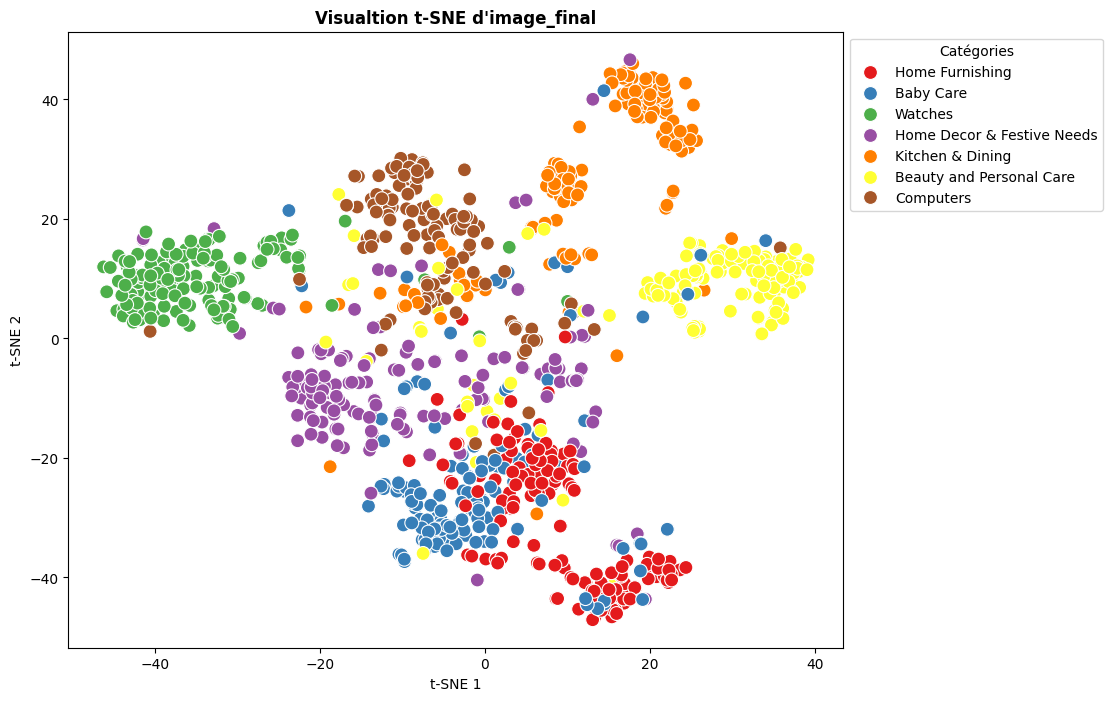

In [42]:
#On peut enfin passer à la visualisation, on commence par image_final
plt.figure(figsize=(10,8))
sns.scatterplot(x=vgg_tsne[:, 0], y=vgg_tsne[:, 1], hue=image_final['categorie_1'], palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE d'image_final", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

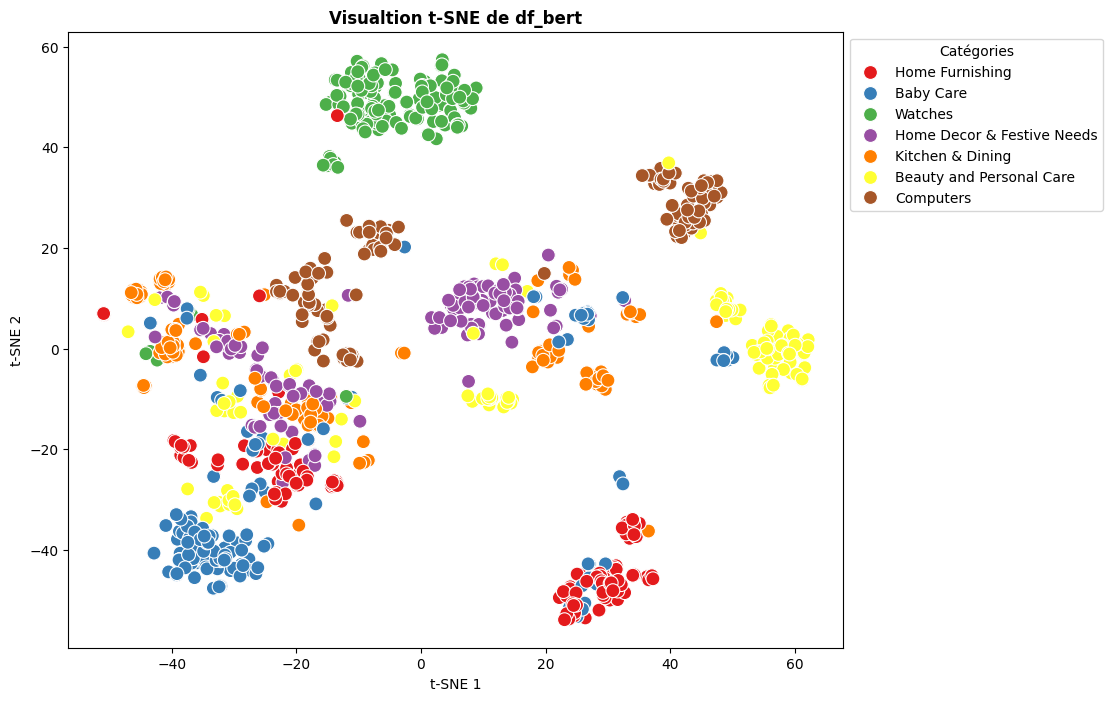

In [43]:
#On enchaîne avec BERT
plt.figure(figsize=(10,8))
sns.scatterplot(x=bert_tsne[:, 0], y=bert_tsne[:, 1], hue=df_bert['categorie_1'], palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE de df_bert", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

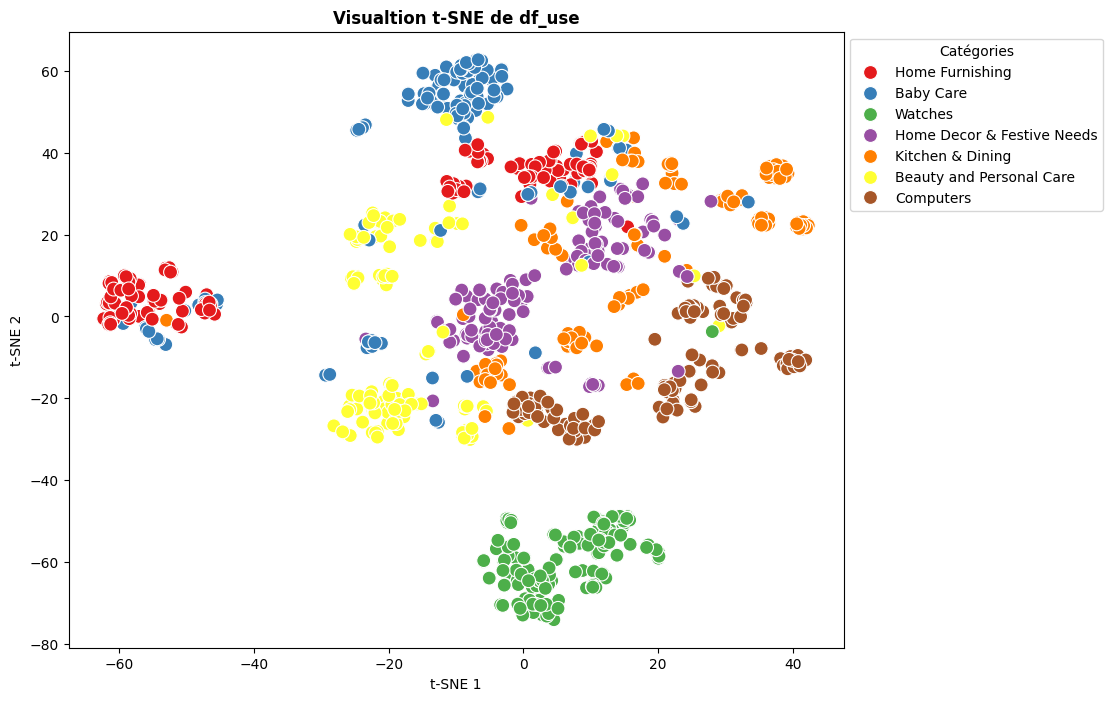

In [44]:
#Puis on finit avec USE
plt.figure(figsize=(10,8))
sns.scatterplot(x=use_tsne[:, 0], y=use_tsne[:, 1], hue=df_use['categorie_1'], palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE de df_use", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

## 2) Etude de faisabilité <a class="anchor" id="iv2"></a>
On passe à l'étude de faisabilité proprement dite. Nous allons entraîner un modèle (KMeans) et calculer l'ARI pour mesurer la similarité entre les clusters réels et les clusters prédits.

In [45]:
#On applique KMeans sur les résultats t-SNE puis on enregistre les clusters prédits dans les dfs respectifs
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=20, random_state=42)
vgg_clusters = kmeans.fit_predict(vgg_tsne)
bert_clusters = kmeans.fit_predict(bert_tsne)
use_clusters = kmeans.fit_predict(use_tsne)

image_final['clusters_kmeans'] = vgg_clusters
df_bert['clusters_kmeans'] = bert_clusters
df_use['clusters_kmeans'] = use_clusters

In [46]:
#KMeans étant aléatoire, on définit une fonction pour réorganiser les clusters
from scipy.optimize import linear_sum_assignment #J'ai essayé une méthode plus "simple" avant, mais elle a rencontré un problème lors de l'application

def conf_mat_transform(y_true, y_pred):
    #Matrice de confusion
    conf_mat = pd.crosstab(y_true, y_pred)
    
    #On convertit en tableau Numpy
    cost_matrix = conf_mat.values
    
    #On applique l'algorithme de Kuhn-Munkres pour trouver la meilleure correspondance
    ligne_ind, col_ind = linear_sum_assignment(-cost_matrix)
    
    #On créé une correspondance dans le cluster
    noms_categ = np.unique(y_true)
    corresp = {col: noms_categ[ligne] for ligne, col in zip(ligne_ind, col_ind)}
    print("Correspondance des clusters : ", corresp)
    
    #On map les clusters prédits aux labels réels en utilisant la correspondance trouvée
    labels = pd.Series(y_pred, name="y_pred").to_frame()
    labels['y_true'] = y_true
    labels['y_pred_transform'] = labels['y_pred'].map(corresp)
    
    return labels['y_pred_transform']

Correspondance des clusters :  {6: 'Baby Care', 4: 'Beauty and Personal Care', 3: 'Computers', 0: 'Home Decor & Festive Needs', 5: 'Home Furnishing', 1: 'Kitchen & Dining', 2: 'Watches'}


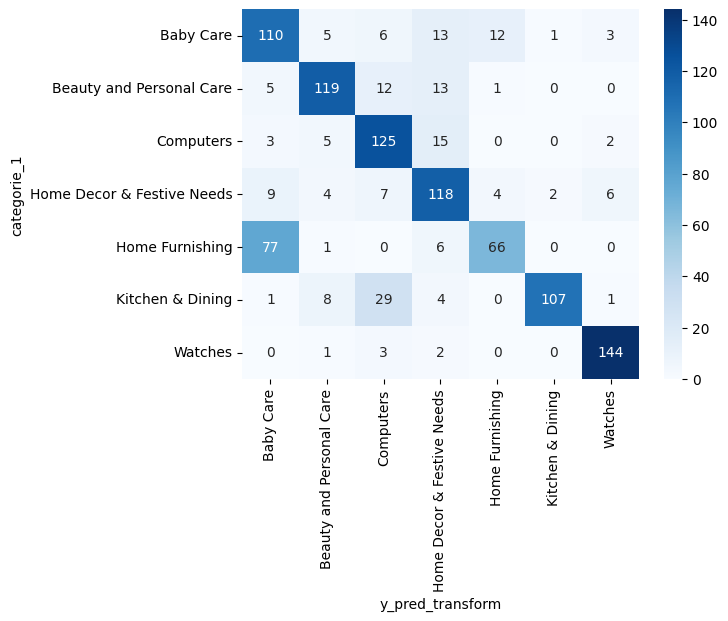

                            precision    recall  f1-score   support

                 Baby Care       0.54      0.73      0.62       150
  Beauty and Personal Care       0.83      0.79      0.81       150
                 Computers       0.69      0.83      0.75       150
Home Decor & Festive Needs       0.69      0.79      0.74       150
           Home Furnishing       0.80      0.44      0.57       150
          Kitchen & Dining       0.97      0.71      0.82       150
                   Watches       0.92      0.96      0.94       150

                  accuracy                           0.75      1050
                 macro avg       0.78      0.75      0.75      1050
              weighted avg       0.78      0.75      0.75      1050



In [48]:
#On commence à nouveau par image_final, on affiche une heatmap ainsi que le classification report
vgg_labels_transform = conf_mat_transform(image_final['categorie_1'], image_final['clusters_kmeans'])
conf_mat = pd.crosstab(image_final['categorie_1'], vgg_labels_transform)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report = metrics.classification_report(image_final['categorie_1'], vgg_labels_transform)
print(report)

#Accuracy = Proportion de prédictions correctes parmi le total des prédictions effectuées
#Precision = Parmi les éléments prédits comme appartenant à une catégorie donnée, combien appartiennent réellement à cette catégorie ?
#Recall = Parmi les éléments qui appartiennent réellement à une catégorie donnée, combien ont été correctement prédits ?
#F1 = Combinaison de precision et recall

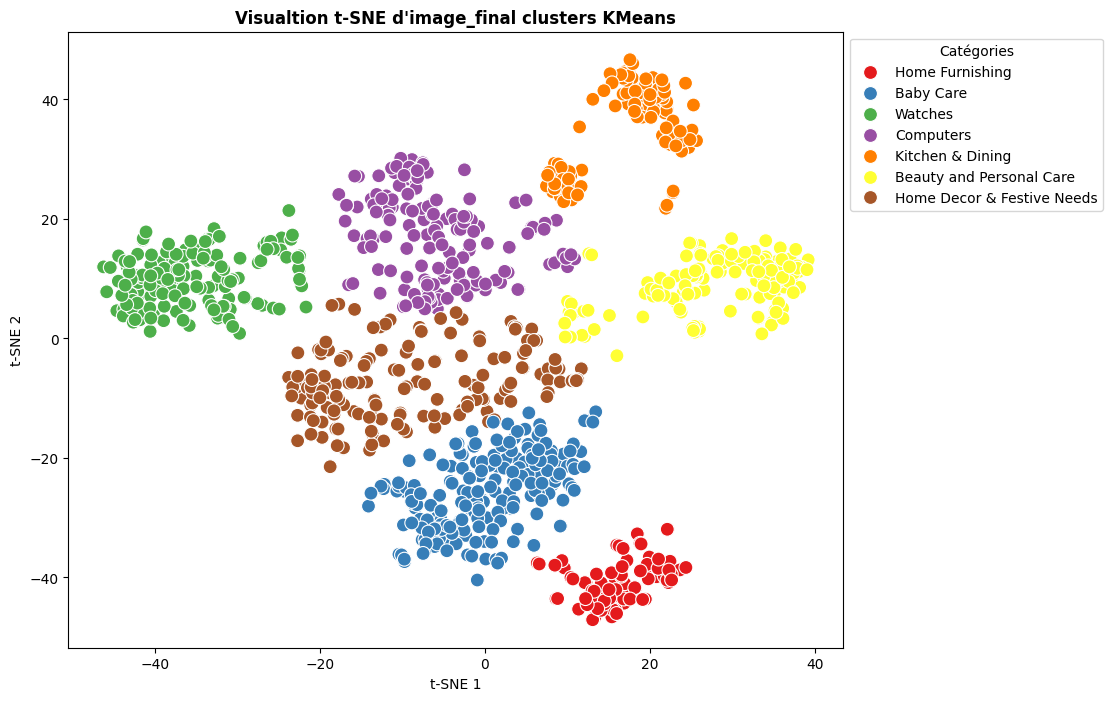

ARI : 0.5480


In [50]:
#A part Baby Care et Home Furnishing, les catégories sont très bien prédites avec ce modèle
#On repasse à la visualisation, et on calcule l'ARI
plt.figure(figsize=(10,8))
sns.scatterplot(x=vgg_tsne[:, 0], y=vgg_tsne[:, 1], hue=vgg_labels_transform, palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE d'image_final clusters KMeans", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

ari_score = metrics.adjusted_rand_score(image_final['categorie_1'], vgg_labels_transform)
print(f"ARI : {ari_score:.4f}")

Correspondance des clusters :  {1: 'Baby Care', 0: 'Beauty and Personal Care', 5: 'Computers', 3: 'Home Decor & Festive Needs', 6: 'Home Furnishing', 4: 'Kitchen & Dining', 2: 'Watches'}


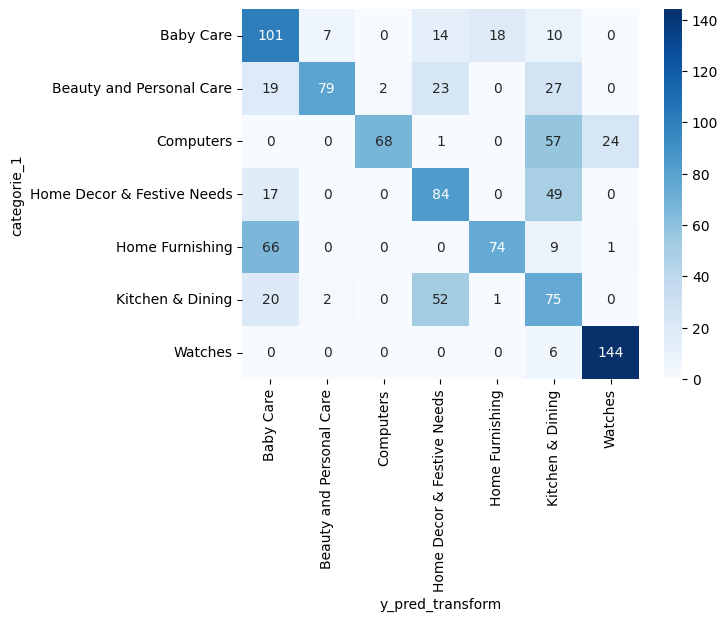

                            precision    recall  f1-score   support

                 Baby Care       0.45      0.67      0.54       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.97      0.45      0.62       150
Home Decor & Festive Needs       0.48      0.56      0.52       150
           Home Furnishing       0.80      0.49      0.61       150
          Kitchen & Dining       0.32      0.50      0.39       150
                   Watches       0.85      0.96      0.90       150

                  accuracy                           0.60      1050
                 macro avg       0.68      0.60      0.61      1050
              weighted avg       0.68      0.60      0.61      1050



In [51]:
#On enchaîne avec BERT
bert_labels_transform = conf_mat_transform(df_bert['categorie_1'], df_bert['clusters_kmeans'])
conf_mat = pd.crosstab(df_bert['categorie_1'], bert_labels_transform)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report = metrics.classification_report(df_bert['categorie_1'], bert_labels_transform)
print(report)

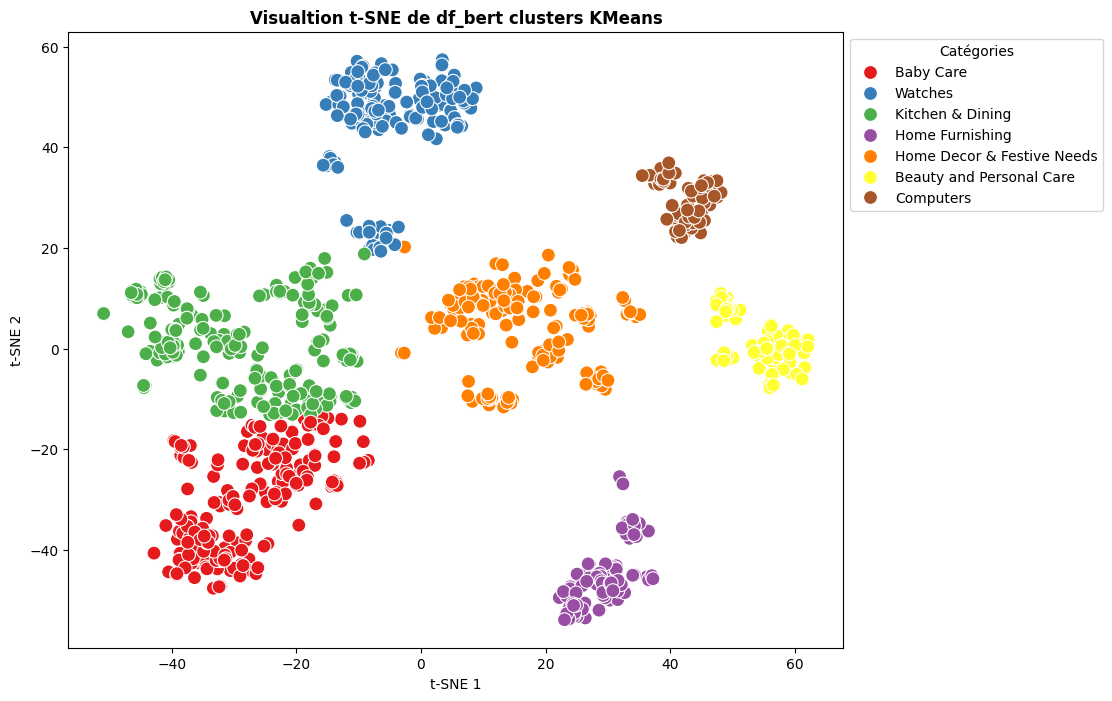

ARI : 0.3429


In [52]:
#On constate que davantage de catégories sont moins bien prédites avec ce modèle
plt.figure(figsize=(10,8))
sns.scatterplot(x=bert_tsne[:, 0], y=bert_tsne[:, 1], hue=bert_labels_transform, palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE de df_bert clusters KMeans", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

ari_score = metrics.adjusted_rand_score(df_bert['categorie_1'], bert_labels_transform)
print(f"ARI : {ari_score:.4f}")

Correspondance des clusters :  {4: 'Baby Care', 5: 'Beauty and Personal Care', 0: 'Computers', 6: 'Home Decor & Festive Needs', 2: 'Home Furnishing', 3: 'Kitchen & Dining', 1: 'Watches'}


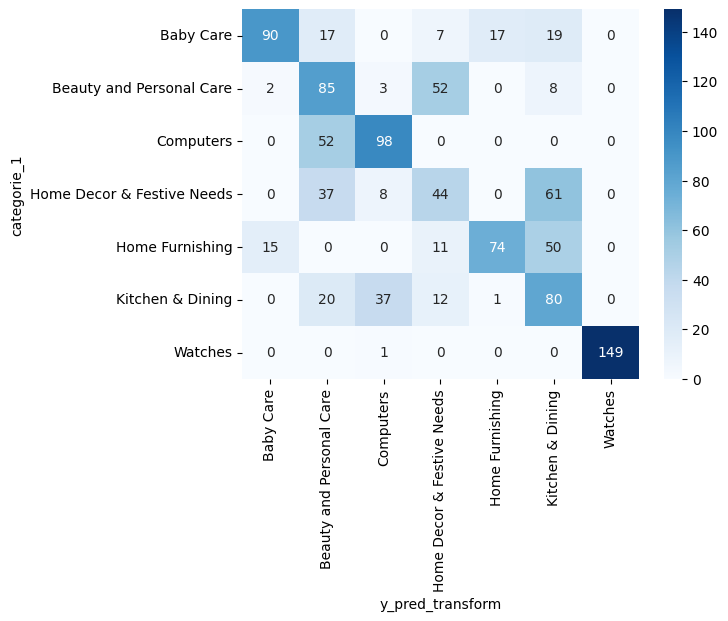

                            precision    recall  f1-score   support

                 Baby Care       0.84      0.60      0.70       150
  Beauty and Personal Care       0.40      0.57      0.47       150
                 Computers       0.67      0.65      0.66       150
Home Decor & Festive Needs       0.35      0.29      0.32       150
           Home Furnishing       0.80      0.49      0.61       150
          Kitchen & Dining       0.37      0.53      0.43       150
                   Watches       1.00      0.99      1.00       150

                  accuracy                           0.59      1050
                 macro avg       0.63      0.59      0.60      1050
              weighted avg       0.63      0.59      0.60      1050



In [53]:
#Puis on finit par USE
use_labels_transform = conf_mat_transform(df_use['categorie_1'], df_use['clusters_kmeans'])
conf_mat = pd.crosstab(df_use['categorie_1'], use_labels_transform)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues')
plt.show()

report = metrics.classification_report(df_use['categorie_1'], use_labels_transform)
print(report)

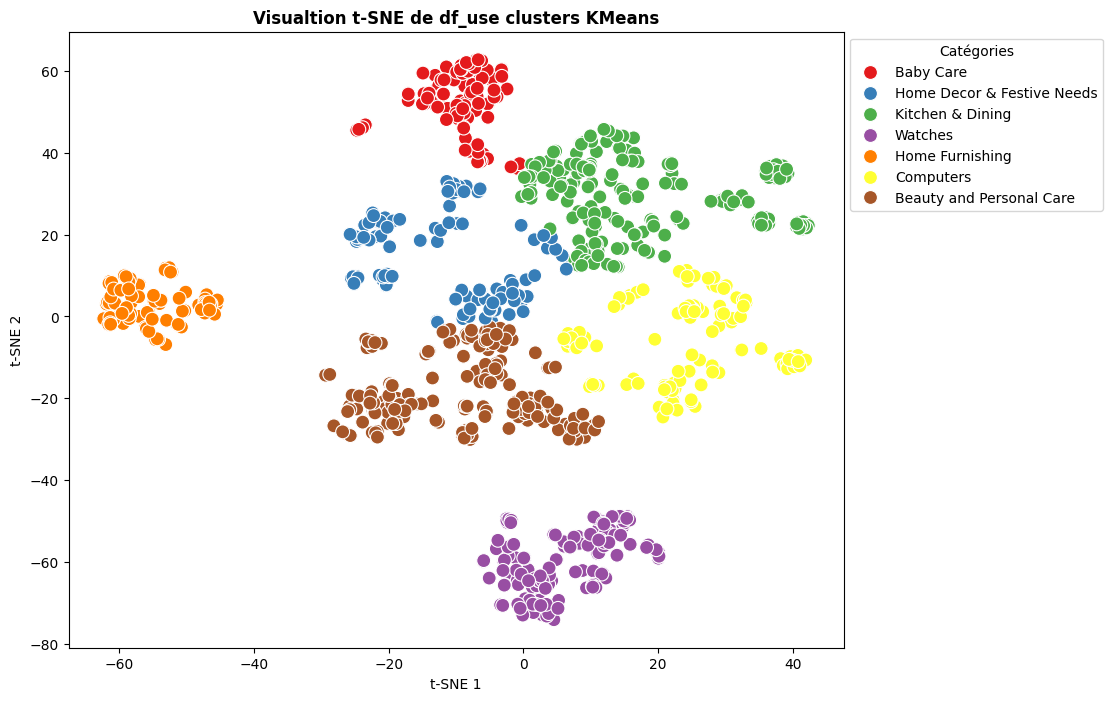

ARI : 0.3737


In [54]:
#Même constat qu'avec BERT
plt.figure(figsize=(10,8))
sns.scatterplot(x=use_tsne[:, 0], y=use_tsne[:, 1], hue=use_labels_transform, palette='Set1', s=100)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title("Visualtion t-SNE de df_use clusters KMeans", weight='bold')
plt.legend(title='Catégories', bbox_to_anchor=(1,1))
plt.show()

ari_score = metrics.adjusted_rand_score(df_use['categorie_1'], use_labels_transform)
print(f"ARI : {ari_score:.4f}")

# Conclusion <a class="anchor" id="conclusion"></a>
L'étude de faisabilité donne des résultats convaincants, notamment à partir des features images. Il semble possible possible de regrouper automatiquement les produits de même catégorie.